![customer.jpg](customer.jpg)

### Context

- In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

- You are required to help the manager to predict the right group of the new customers.

In [1]:
#general 
import pandas as pd
import numpy as np

np.random.seed(42)

# pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
df_train = pd.read_csv(r'C:\Users\migue\Documents\datasets_kaggle\customer_segmentation\train.csv')

In [3]:
df_train.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 472.8+ KB


In [5]:
df_train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


#### are there null values?

In [6]:
df_train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

#### Is the exists duplicated values?

In [7]:
print("Rows before drop the duplicated values: ", len(df_train))
print("Rows after drop the duplicated values: ", len(df_train.drop_duplicates(keep = "first")))

Rows before drop the duplicated values:  8068
Rows after drop the duplicated values:  8068


### Explore the data

- There are more Male than Female into the dataset as a consequence may a higher proportion of missing data for Male

In [8]:
df_train[["Gender", "ID"]].groupby(by = "Gender").count()

,ID
Gender,
Female,3651
Male,4417


In [9]:
print("Male:", (len(df_train[df_train.Gender == "Male"]) / len(df_train)) * 100)
print("Female:",(len(df_train[df_train.Gender == "Female"]) / len(df_train)) * 100)

Male: 54.74714923153198
Female: 45.25285076846802


<AxesSubplot:xlabel='Gender', ylabel='count'>

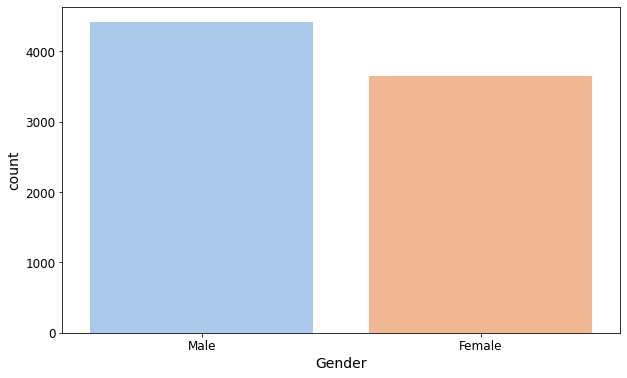

In [10]:
import seaborn as sns

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x = "Gender", data = df_train, palette = "pastel", ax = ax)

#### `Ever Married`
- There are more female that never been married before in comparision with already been married

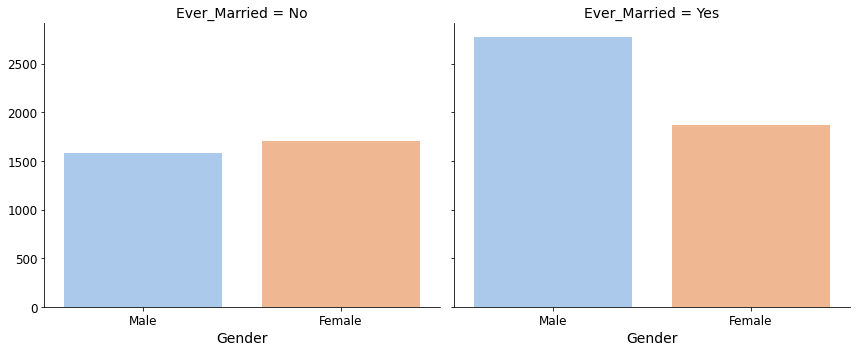

In [11]:
g = sns.FacetGrid(df_train, col = "Ever_Married", height = 5, aspect = 1.2)
g.map(sns.countplot, "Gender", palette = "pastel", order = ["Male", "Female"])

#### `Spending Score`
- There are more male spend more money in all the categories

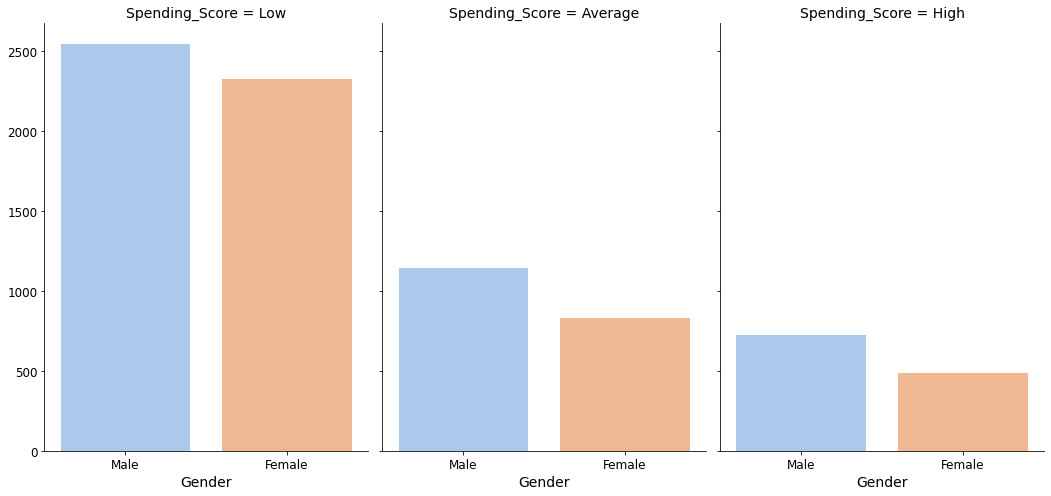

In [12]:
g = sns.FacetGrid(df_train, col = "Spending_Score", height = 7, aspect = 0.7)
g.map(sns.countplot, "Gender", palette = "pastel", order = ["Male", "Female"])

`Spending Score by segmentation`
- Most of the market is into segments low & average (85% of the total dataset)

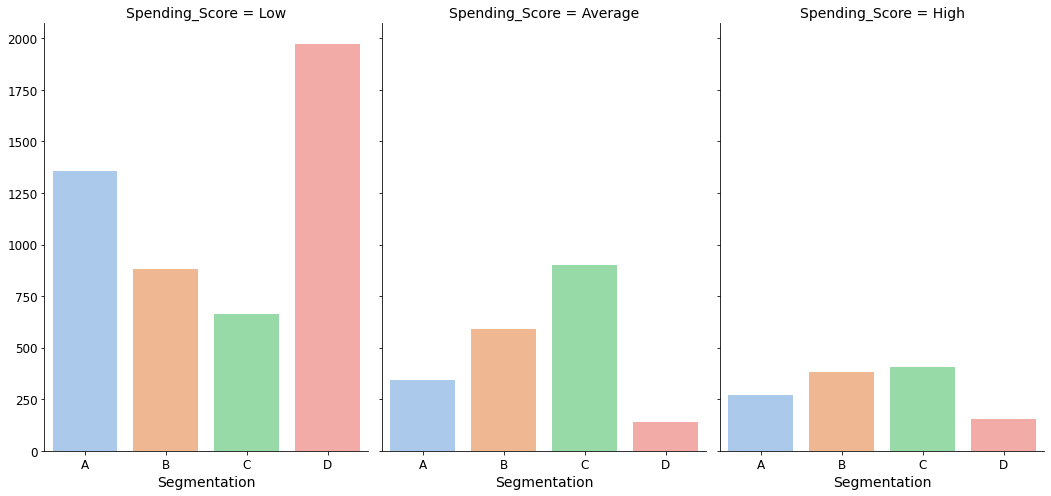

In [13]:
g = sns.FacetGrid(df_train, col = "Spending_Score", height = 7, aspect = 0.7)
g.map(sns.countplot, "Segmentation", palette = "pastel", order = ["A", "B", "C", "D"])

In [14]:
print("Segmentation(Low): ",len(df_train[df_train.Spending_Score == "Low"]) / len(df_train) * 100)
print("Segmentation(Average): ",len(df_train[df_train.Spending_Score == "Average"]) / len(df_train) * 100)
print("Segmentation(High): ",len(df_train[df_train.Spending_Score == "High"]) / len(df_train) * 100)

Segmentation(Low):  60.46108081308874
Segmentation(Average):  24.467030242935053
Segmentation(High):  15.071888943976203


`Spending Score by proffesion`
- Most of the individues are artist or healthcare

In [15]:
df_train[["Profession", "ID"]].groupby(by = "Profession", as_index = False).count().sort_values(by = "ID", ascending = False)

,Profession,ID
0,Artist,2516
5,Healthcare,1332
3,Entertainment,949
2,Engineer,699
1,Doctor,688
7,Lawyer,623
4,Executive,599
8,Marketing,292
6,Homemaker,246


`Histrograms`
- Most of the individues do not have an extensive work experience, the reason is some are ungraduated
- Most of the individues are among 30's & 40's

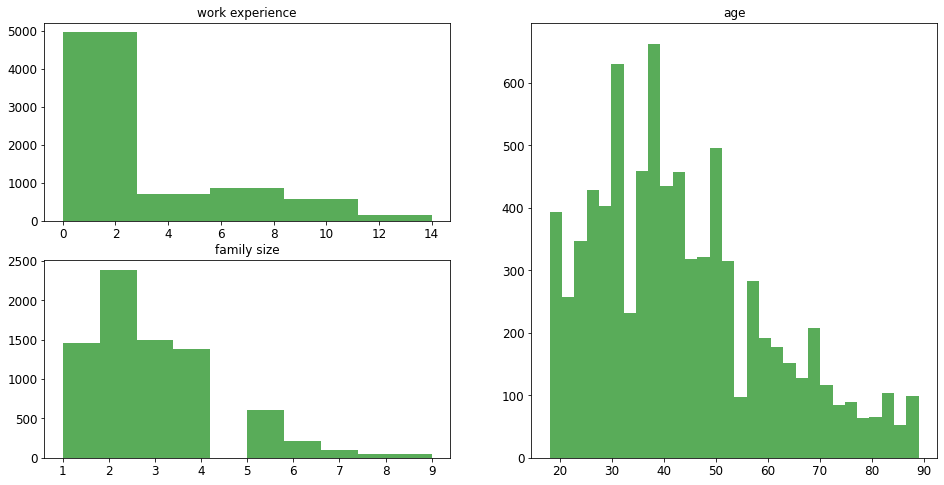

In [16]:
plt.figure(figsize = (16, 8))

plt.subplot(221)
plt.hist(df_train.Work_Experience, bins = 5, color = "g", alpha = 0.65)
plt.title("work experience")

plt.subplot(122)
plt.hist(df_train.Age, bins = 30, color = "g", alpha = 0.65)
plt.title("age")

plt.subplot(223)
plt.hist(df_train.Family_Size, bins = 10, color = "g", alpha = 0.65)
plt.title("family size")

plt.show()

#### `Correlation among variables`
- https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

In [17]:
df_train.head(1)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D


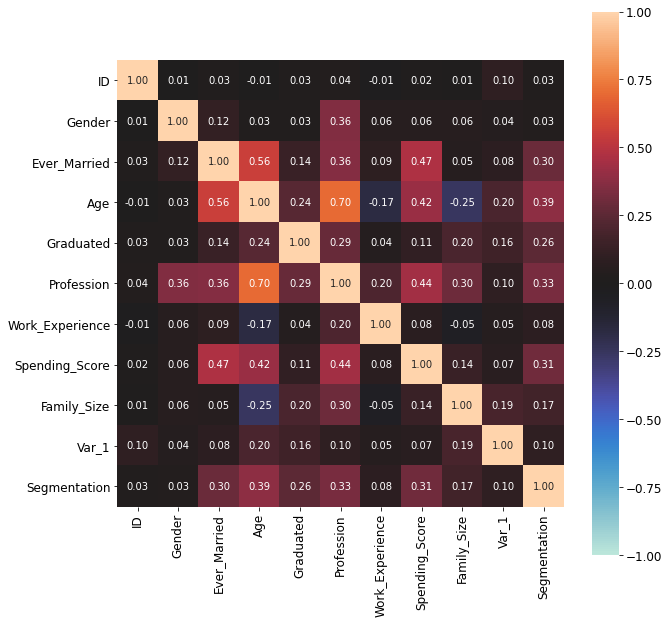

{'corr':                        ID    Gender  Ever_Married       Age  Graduated  \
 ID               1.000000  0.006155      0.027152 -0.005055   0.029552   
 Gender           0.006155  1.000000      0.116535  0.030216   0.031225   
 Ever_Married     0.027152  0.116535      1.000000  0.562482   0.139935   
 Age             -0.005055  0.030216      0.562482  1.000000   0.235966   
 Graduated        0.029552  0.031225      0.139935  0.235966   1.000000   
 Profession       0.038579  0.355667      0.360149  0.699355   0.288906   
 Work_Experience -0.012364  0.056866      0.090545 -0.174199   0.042715   
 Spending_Score   0.021694  0.061412      0.474810  0.416633   0.106479   
 Family_Size      0.014424  0.062391      0.048648 -0.253113   0.197076   
 Var_1            0.099664  0.043639      0.081284  0.201236   0.159416   
 Segmentation     0.028716  0.032324      0.295569  0.388250   0.256881   
 
                  Profession  Work_Experience  Spending_Score  Family_Size  \
 ID         

In [18]:
from dython.nominal import associations

associations(df_train, theil_u = False, figsize = (10, 10))

### Conlusion from explore the data
- There are many variables and many of them are not important to predict the segmentation, as example is most importat the Age over the Gender
- Into the dataset there are more female than male, the above is important if you wanna to take get insights, to get good insights the base is good sample
- Base on the above point 

### Predicting the target
- The first step is to split the train dataset

#### Preprocessing

In [19]:
from sklearn.model_selection import train_test_split

df_train2, df_val = train_test_split(df_train, test_size = 0.2, random_state = 42)
print("total:", len(df_train))
print(len(df_train2), "train + ", len(df_val), "validation")

total: 8068
6454 train +  1614 validation


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.impute import SimpleImputer

except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["Age", "Work_Experience", "Family_Size"])),
    ("imputer", SimpleImputer(strategy = "median")),
    ("std_scaler", StandardScaler())
])

In [22]:
num_pipeline.fit_transform(df_train2)

array([[-0.33195458, -0.45338846,  0.75879927],
       [-0.6306267 , -0.75775387,  1.42627788],
       [ 0.32512408, -0.45338846, -1.24363654],
       ...,
       [-0.21248573,  0.45970779, -1.24363654],
       [-0.86956439, -0.75775387,  1.42627788],
       [-0.98903324, -0.45338846,  4.09619229]])

In [23]:
# ========================================================================================================
# ========================================================================================================
# fill missing values for categorical strings

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index = X.columns)
        return self
    
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent_)
    
# ========================================================================================================
# ========================================================================================================

try:
    from sklearn.preprocessing import OrdinalEncoder
    from sklearn.preprocessing import OneHotEncoder

except ImportError:
    from future_encoders import OneHotEncoder

In [24]:
df_train.head(1)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D


In [25]:
cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse = False)),
])

In [26]:
cat_pipeline.fit_transform(df_train2)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

In [27]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list = [
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [28]:
X_train = preprocess_pipeline.fit_transform(df_train2)
X_train

array([[-0.33195458, -0.45338846,  0.75879927, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6306267 , -0.75775387,  1.42627788, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32512408, -0.45338846, -1.24363654, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.21248573,  0.45970779, -1.24363654, ...,  0.        ,
         1.        ,  0.        ],
       [-0.86956439, -0.75775387,  1.42627788, ...,  0.        ,
         0.        ,  0.        ],
       [-0.98903324, -0.45338846,  4.09619229, ...,  0.        ,
         1.        ,  0.        ]])

In [29]:
y_train = df_train2["Segmentation"]

In [30]:
X_val = preprocess_pipeline.fit_transform(df_val)
y_val = df_val["Segmentation"]

#### Ensemble learning

- `Hard voting`

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C = 10, random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)
svm_clf = SVC(kernel = "poly", degree = 3)

voting_clf = VotingClassifier( 
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

In [32]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10,
                                                 multi_class='multinomial',
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(kernel='poly'))])

In [33]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.49566294919454773
RandomForestClassifier 0.45539033457249073
SVC 0.5117719950433705
VotingClassifier 0.5092936802973977


- `Soft voting`

In [34]:
log_clf = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C = 10, random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 10, random_state = 42)
svm_clf = SVC(gamma = "auto", probability = True, random_state = 42)

voting_clf = VotingClassifier( 
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10,
                                                 multi_class='multinomial',
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc',
                              SVC(gamma='auto', probability=True,
                                  random_state=42))],
                 voting='soft')

In [35]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.49566294919454773
RandomForestClassifier 0.45539033457249073
SVC 0.5136307311028501
VotingClassifier 0.5142503097893433


- `Bagging`

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier as DTC

bag_clf = BaggingClassifier(
    DTC(random_state = 42), n_estimators = 1000,
    max_samples = 100, bootstrap = True, n_jobs = -1, random_state = 42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_val)

In [37]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.5272614622057001


- `Random Forest`

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 42)
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.4739776951672863


- `Ada Boost`

In [39]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DTC(max_depth = 1), n_estimators = 1000, algorithm = "SAMME.R", 
    learning_rate = 0.1, random_state = 42)

ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.5185873605947955


- `Gradient Boosting`

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0,
                                    max_depth = 2, random_state = 42)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.5074349442379182


### Grid search for Bagging

- `Bagging - ramdomized search`

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators' : randint(low = 10, high = 1000),
    'max_samples' : randint(low = 100, high = 1000),
    #'bootstrap' = True,
    #'n_jobs' = -1
}

bag_clf = BaggingClassifier(
    DTC(random_state = 42), bootstrap = True, n_jobs = -1, random_state = 42
)

bag_search = RandomizedSearchCV(bag_clf, param_distributions = param_distribs,
                                n_iter = 16, cv = 7, random_state = 42)

bag_search.fit(X_train, y_train)

RandomizedSearchCV(cv=7,
                   estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                               n_jobs=-1, random_state=42),
                   n_iter=16,
                   param_distributions={'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1E237478>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1E237370>},
                   random_state=42)

In [42]:
bag_search.best_estimator_

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_samples=430, n_estimators=468, n_jobs=-1,
                  random_state=42)

In [43]:
bag_search.best_params_

{'max_samples': 430, 'n_estimators': 468}

In [44]:
bag_clf_best_model = bag_search.best_estimator_
y_pred_bag_clf_best_model = bag_clf_best_model.predict(X_val)
print(accuracy_score(y_val, y_pred_bag_clf_best_model))

0.5322180916976456


- `Ada boost - ramdomized search`

In [45]:
from scipy.stats import uniform

ada_param_distribs = {
    'n_estimators' : randint(low = 10, high = 1000),
    'learning_rate' : uniform(0.1, 1.5),     
}

ada_clf = AdaBoostClassifier(
    DTC(max_depth = 1), algorithm = "SAMME.R", random_state = 42)

ada_search = RandomizedSearchCV(ada_clf, param_distributions = ada_param_distribs, 
                                n_iter = 16, cv = 7, random_state = 42)
ada_search.fit(X_train, y_train)

RandomizedSearchCV(cv=7,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                random_state=42),
                   n_iter=16,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x25FC0340>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1E237310>},
                   random_state=42)

In [46]:
ada_search.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1871254182522992, n_estimators=97,
                   random_state=42)

In [47]:
ada_search.best_params_

{'learning_rate': 0.1871254182522992, 'n_estimators': 97}

In [48]:
ada_clf_best_model = ada_search.best_estimator_
y_pred_ada_clf_best_model = ada_clf_best_model.predict(X_val)
print(accuracy_score(y_val, y_pred_ada_clf_best_model))

0.5061957868649318


## Conclusion

- At the final the best algorithm is the Bagging classifier with a efficiency of 52.7% and after try a fine tunning it improve to 53.2%

- Another good predicter for this exercise is Ada Boost classifier with a efficiency of 51.8% but after a fine tuning, the eficciency goes down to 50.6%

- The main propose of this exercise is evaluated the differents ensamble methods in order to create a good predict algorithm

- Before jump to create a predictor is important to get insights from the data in order to know the most imporatant variables, understand the problem and figure out if the data make sense